# 2024-02-18 blog: How to Model Features as Expected Returns
https://robotwealth.com/how-to-model-features-as-expected-returns/

In [ ]:
install.packages("pacman")
install.packages("tidyfit")

In [ ]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tidyfit)
library(tibbletime)
library(roll)
library(patchwork)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

In [21]:
perps <- read_csv("https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv")
# head(perps)
perps %>%
    filter( ticker=="BTCUSDT") %>%
    tail()

Rows: 187251 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (9): open, high, low, close, dollar_volume, num_trades, taker_buy_volum...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2024-02-08,43057.7,45450.0,42992.2,45406.3,15566736863,3919066,181038.5,8036868484,-0.00019125
BTCUSDT,2024-02-09,45406.4,47699.5,44878.0,47136.9,21567170395,5043069,236164.3,10963448921,-0.00022961
BTCUSDT,2024-02-10,47137.0,48230.3,46836.4,47332.0,11649406875,2944511,124731.8,5914214929,-0.00028041
BTCUSDT,2024-02-11,47331.9,48600.0,47139.0,48140.8,11261669160,3007517,117939.9,5660935220,-0.00030000
BTCUSDT,2024-02-12,48140.7,49965.3,47702.0,49925.4,15752123347,3902871,167342.8,8128532918,-0.00030000
BTCUSDT,2024-02-13,49925.5,50428.8,48356.0,48753.1,22702991577,5468794,223860.1,11119813668,-0.00030000


For the purposes of this example, we’ll create the same crypto universe that we used last time – the top 30 Binance perpetual futures contracts by trailing 30-day dollar-volume, with stables and wrapped tokens removed.

We’ll also calculate returns at this step for later use.

In [46]:
# get same universe as before - top 30 by rolling 30-day dollar volume, no stables

# remove stablecoins
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  httr::content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# sort(stables)

perps <- perps %>%
  filter(!ticker %in% glue::glue("{stables}USDT"))

## top 30 by trailing 30-day volume

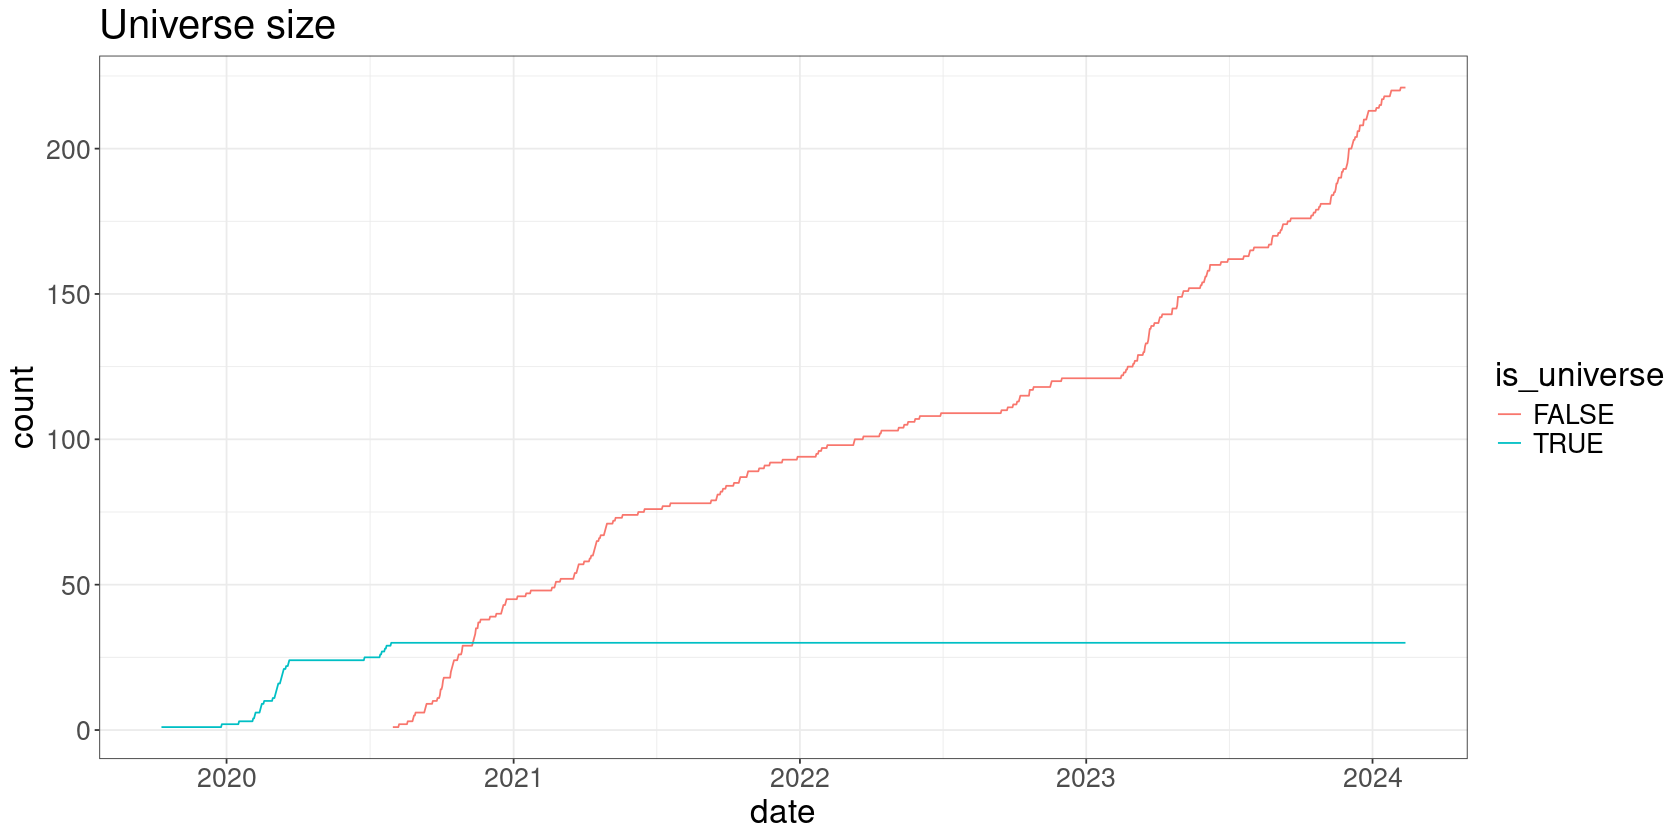

In [54]:
# get the top 30 by trailing 30-day volume
trading_universe_size <- 30

universe <- perps %>%
  group_by(ticker) %>%
  # also calculate returns for later
  mutate(
    total_return_simple = funding_rate + (close - lag(close, 1))/lag(close, 1),
    total_return_log = log(1 + total_return_simple),
    total_fwd_return_simple = dplyr::lead(funding_rate, 1) + (dplyr::lead(close, 1) - close)/close,
    total_fwd_return_log = log(1 + total_fwd_return_simple)
  ) %>%
# calculcate delta feature
  mutate(
      sell_volume = num_trades - taker_buy_volume,
      delta = sell_volume - taker_buy_volume ) %>%
  mutate(trail_volume = roll_mean(dollar_volume, 30)) %>%
  na.omit() %>%
  group_by(date) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size,
  )

universe %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) +
  geom_line() +
  labs(
    title = 'Universe size'
)

In [66]:
# calculate features as before
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 20, na_value = NA),
  otherwise = NA
)

features <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = 9.5 - rolling_days_since_high_20(close),  # puts this feature on a scale -9.5 to +9.5
    momo = close - lag(close, 10)/close,
    carry = funding_rate
  ) %>%
  ungroup() %>%
  na.omit()

# create a model df on our universe with momo and carry features scaled into deciles
model_df <- features %>%
  filter(is_universe) %>%
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    momo_decile = ntile(momo, 10),
    # delta
    delta_zscore = (delta - mean(delta, na.rm = TRUE)) / sd(delta, na.rm = TRUE),
    delta_decile = ntile(delta, 10),
    # also calculate demeaned return for everything in our universe each day for later
    demeaned_return = total_return_simple - mean(total_return_simple, na.rm = TRUE),
    demeaned_fwd_return = total_fwd_return_simple - mean(total_fwd_return_simple, na.rm = TRUE),
  ) %>%
  ungroup()

  # start simulation from date we first have n tickers in the universe
start_date <- features %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(date)

# perps %>%
#     filter( ticker=="BTCUSDT") %>%
#     select(-taker_buy_quote_volumne) %>%
#     # select(-dollar_volume, -taker_buy_quote_volumne) %>%
#     rename(buy_volume = taker_buy_volume, volume = num_trades) %>%
#     mutate(
#         sell_volume = volume - buy_volume,
#         delta = sell_volume - buy_volume ) %>%
#     select(ticker, date, open:close, volume, buy_volume, sell_volume, delta, everything()) %>%
#     tail()

## Exploring features

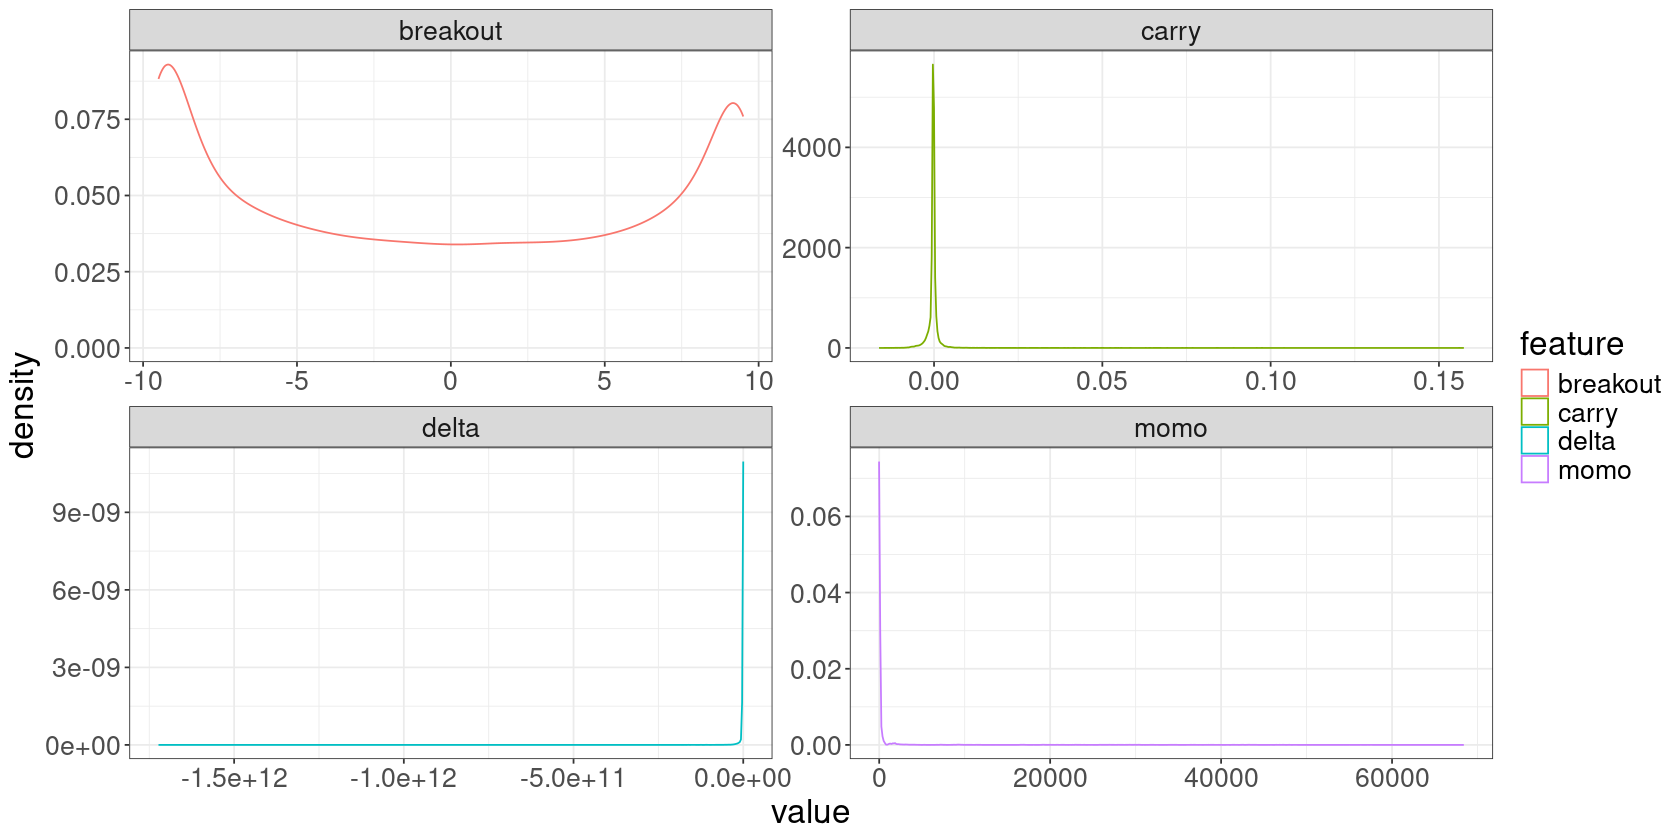

In [59]:
features %>%
  filter(is_universe) %>%
  pivot_longer(c(breakout, momo, carry, delta), names_to = "feature") %>%
  ggplot(aes(x = value, colour = feature)) +
  geom_density() +
  facet_wrap(~feature, scales = "free")

We see that the breakout feature is not too badly behaved. Carry and momentum both have significant tails however, so we’re going to want to scale those features somehow.

We’ll scale them cross sectionally by:

calculating a zscore: the number of standard deviations each asset is away from the daily mean
sorting into deciles: sort the assets into 10 equal buckets by the value of the feature each day – this collapses the feature value down to a rank for each asset each day (multiple assets will have the same rank).

We’ll also calculate relative returns so that we can explore our features’ predictive utility in the time-series and the cross-section.


## Expected returns

### Carry feature

Now that we have our features, we can model expected returns.

In the article on Quantifying and Combining Alphas, we saw that the carry feature showed a very rough and noisily linear relationship with forward cross-sectional returns. It looks even nicer, although not perfectly linear, on our cut-down universe:


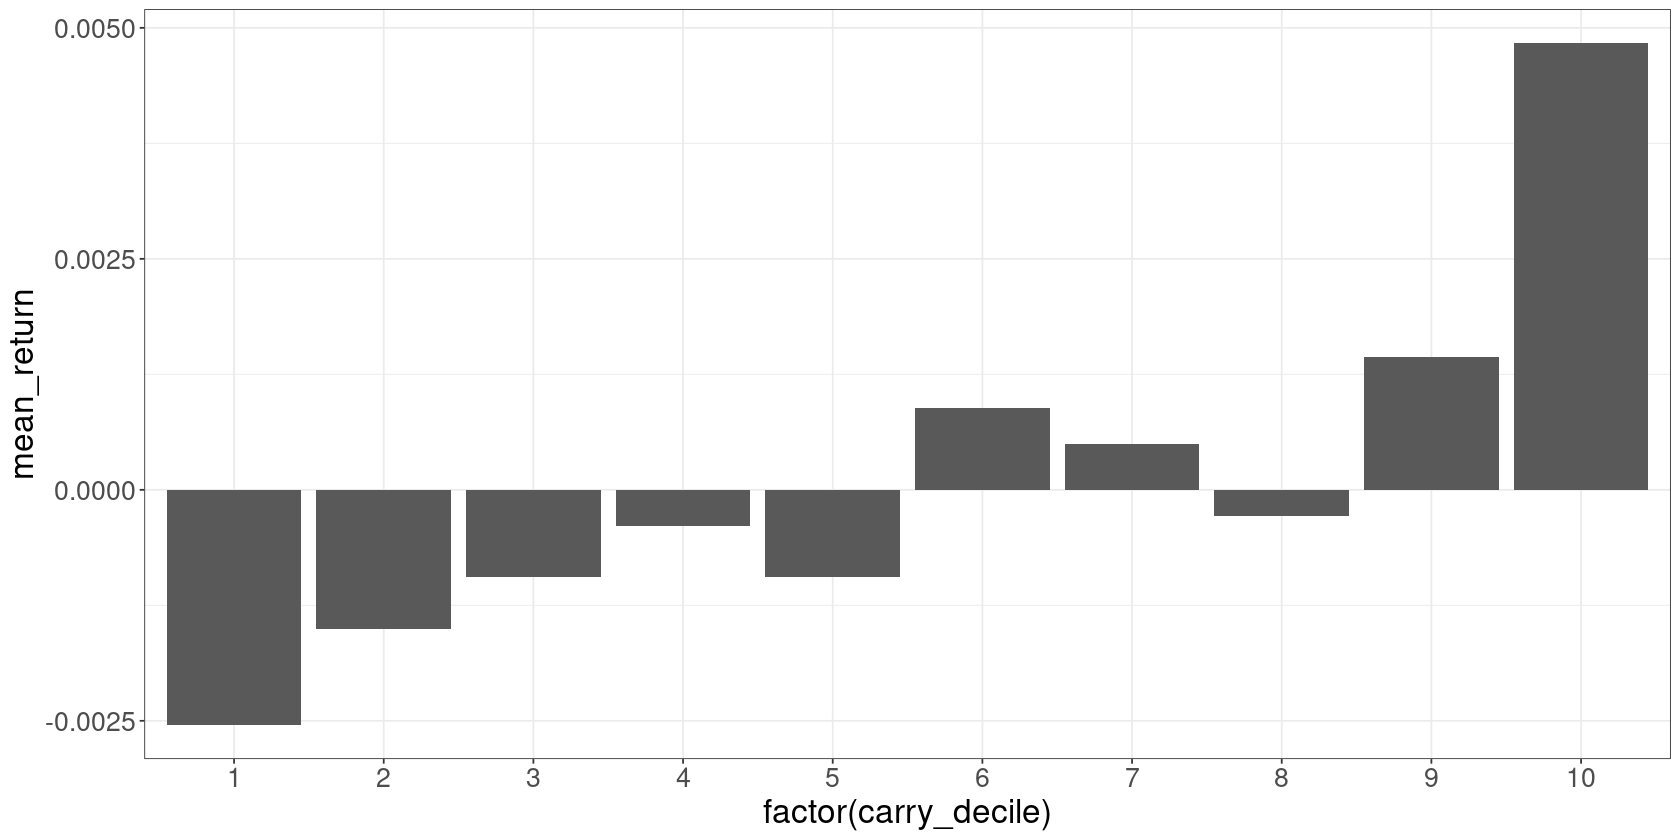

In [50]:
model_df %>%
  group_by(carry_decile) %>%
  summarise(mean_return = mean(demeaned_fwd_return)) %>%
  ggplot(aes(x = factor(carry_decile), y = mean_return)) +
  geom_bar(stat = "identity")

While not perfectly linear in expected returns, it would be entirely acceptable to model this feature with a simple linear model. In fact, it’s probably the optimal thing to do because it will limit your ability to overfit to the past. Having said that, to the extent that the outlying return to the tenth decile is real and stable through time, you might explicitly account for it in your model – I’d probably just keep things simple though.

In contrast, the momentum feature doesn’t look quite so nice on our cut-down universe. In fact, it looks quite random:

### MOMO

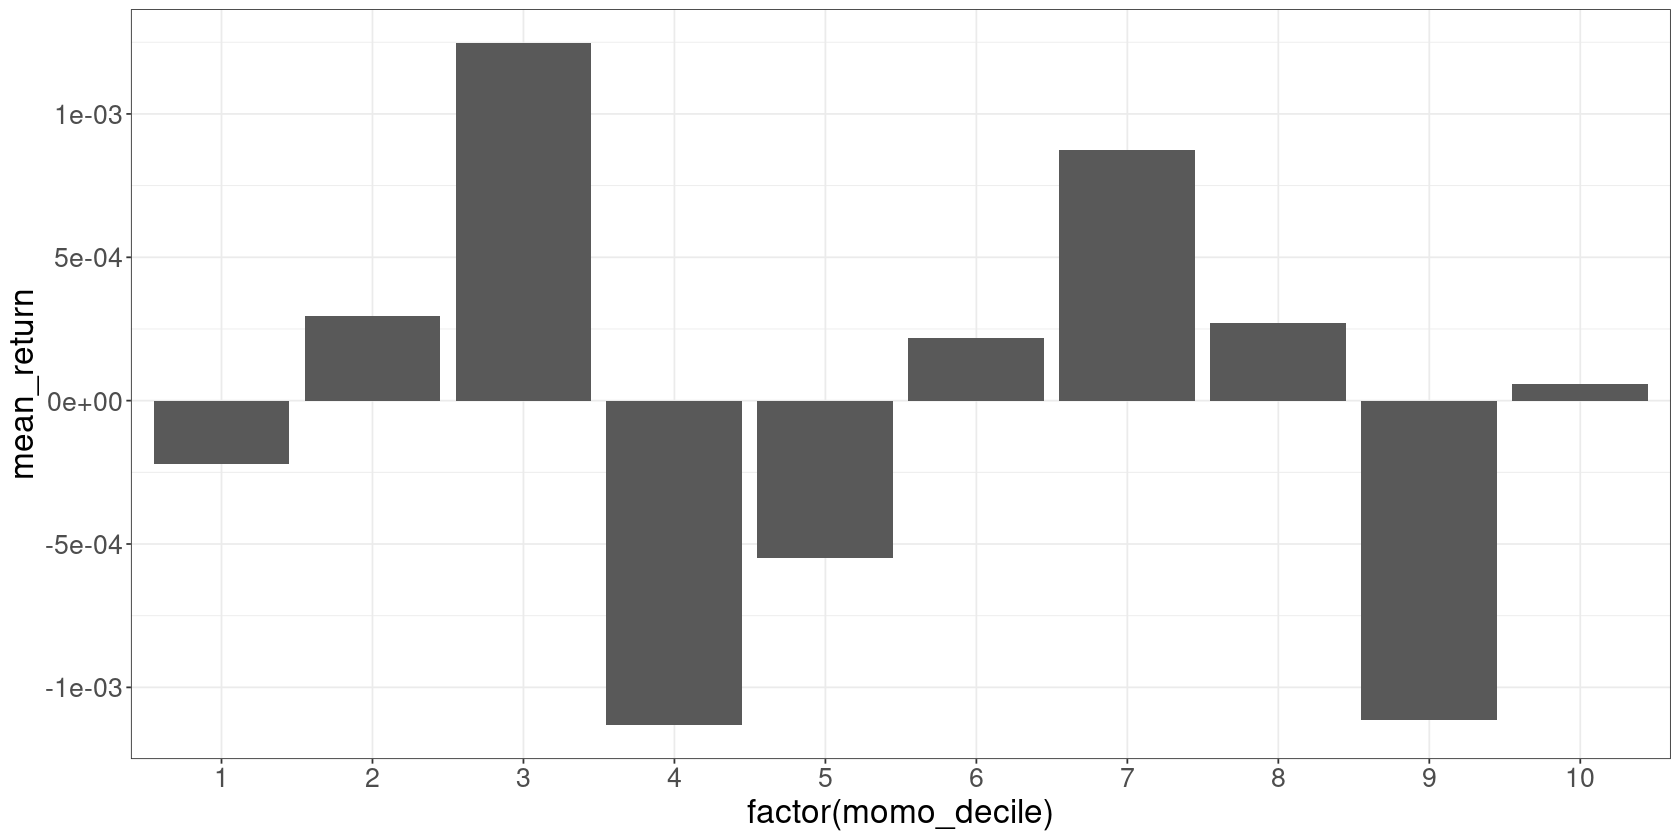

In [51]:
model_df %>%
  group_by(momo_decile) %>%
  summarise(mean_return = mean(demeaned_fwd_return)) %>%
  ggplot(aes(x = factor(momo_decile), y = mean_return)) +
  geom_bar(stat = "identity")

This is interesting. Perhaps there’s some liquidity dependency here given that the factor looks rather non-predictive on our more-liquid universe (although it didn’t look so good on our larger universe either).

But at this point, it’s hard to make the case for a linear model doing this feature justice.

Let’s see how this feature’s relationship with forward returns has changed over time. We’ll plot a factor plot for each year in our data set:


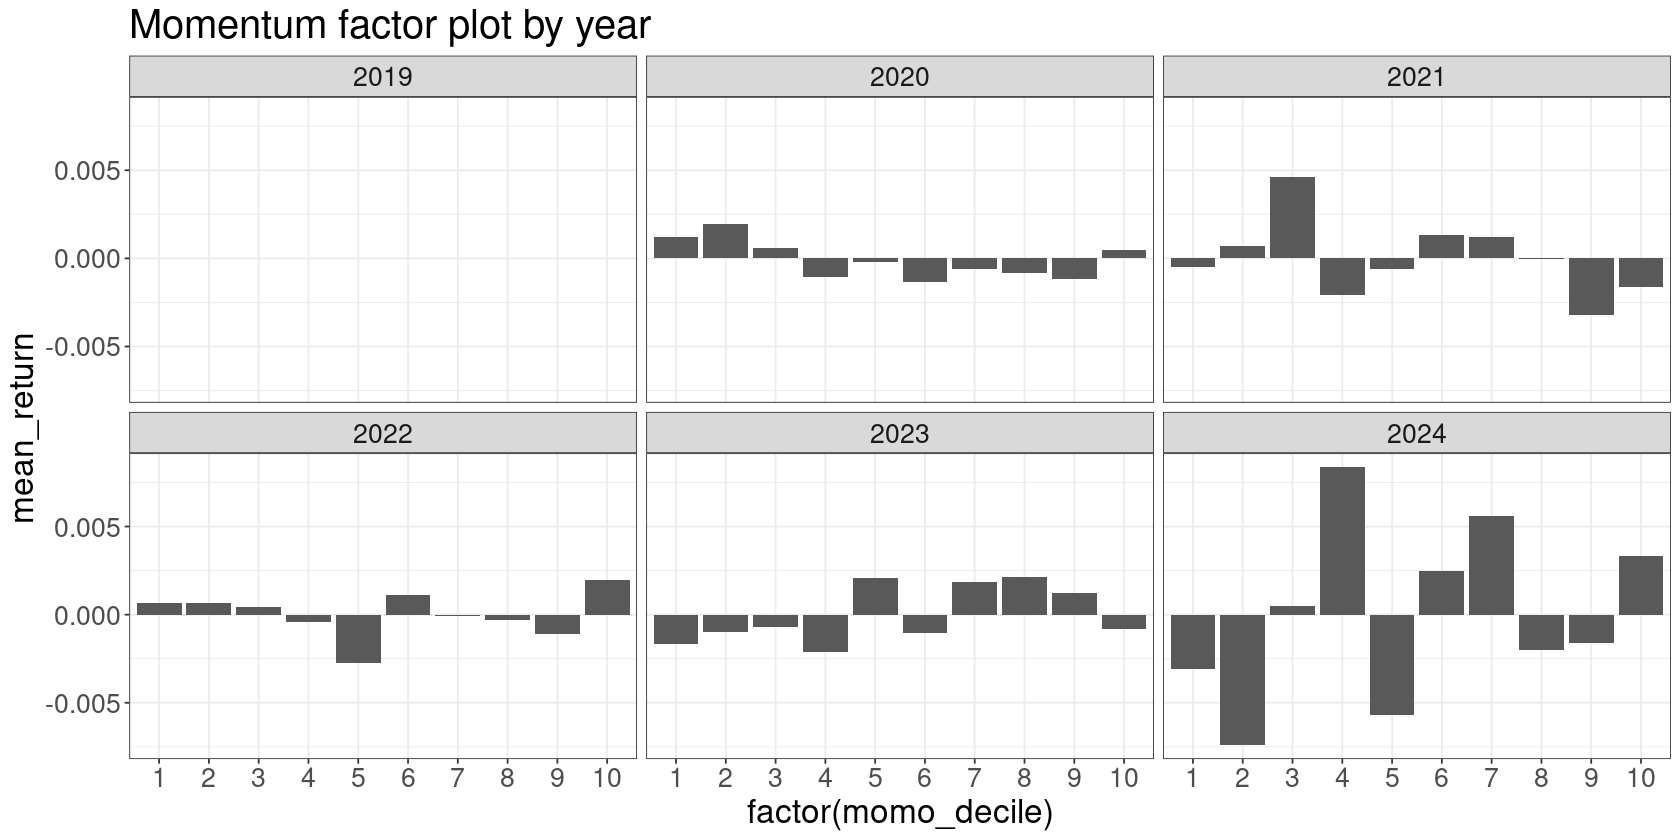

In [52]:
model_df %>%
  mutate(Year = year(date)) %>%
  group_by(momo_decile, Year) %>%
  summarise(mean_return = mean(demeaned_fwd_return, na.rm = TRUE), .groups = "drop") %>%
  ggplot(aes(x = factor(momo_decile), y = mean_return)) +
  geom_bar(stat = "identity") +
  facet_wrap(~Year) +
  labs(
    title = "Momentum factor plot by year"
  )

Interesting. You could argue that in 2020, 2021, and (maybe) 2022, the momentum feature showed a noisy inverse relationship, implying mean reversion. In 2023 and 2024, that looks to have flipped.

When we take all the years together as in the first plot, it looks like a big random mess. But digging a bit deeper reveals a (potentially) real but changing relationship instead. And you could make a case that a linear model was a reasonable choice for each year in the plot above… it’s just that a different model seems appropriate for each year.

One significant benefit of the approach we’ll use here is that you can update your model of expected returns through time, and thus capture changing relationships such as this.

As an aside, this is the sort of analysis you’d do for all of your features – you really want to understand them in as much detail as possible. But this is already going to be a long article, so let’s press on.

Next let’s check what our breakout feature looks like:


### Breakout

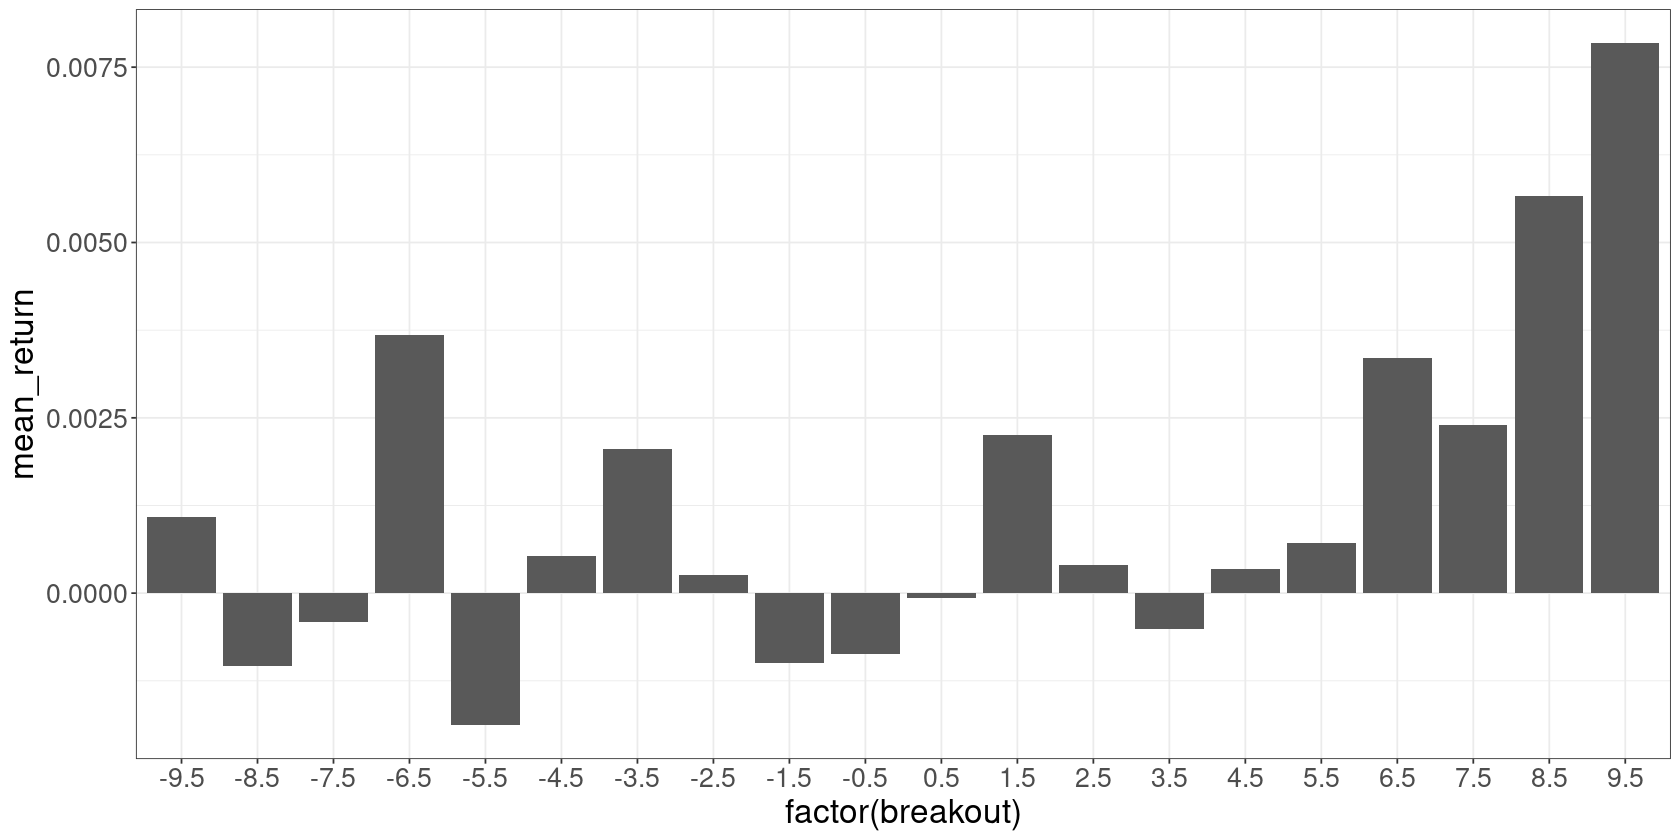

In [60]:
model_df %>%
  group_by(breakout) %>%
  summarise(mean_return = mean(total_fwd_return_simple)) %>%
  ggplot(aes(x = factor(breakout), y = mean_return)) +
  geom_bar(stat = "identity")

This provides another good example of thinking about a model that adequately describes our feature.

You can see that for the values -9.5 through about 3.5, the relationship with forward returns looks entirely random.

But from about 4.5 onwards, it looks quite non-random. You could argue for a linear model on this portion of the feature’s range. This leads to a stepwise linear model of expected returns, where expected returns are zero for -9.5 through 3.5 and linear from 3.5 through 9.5.


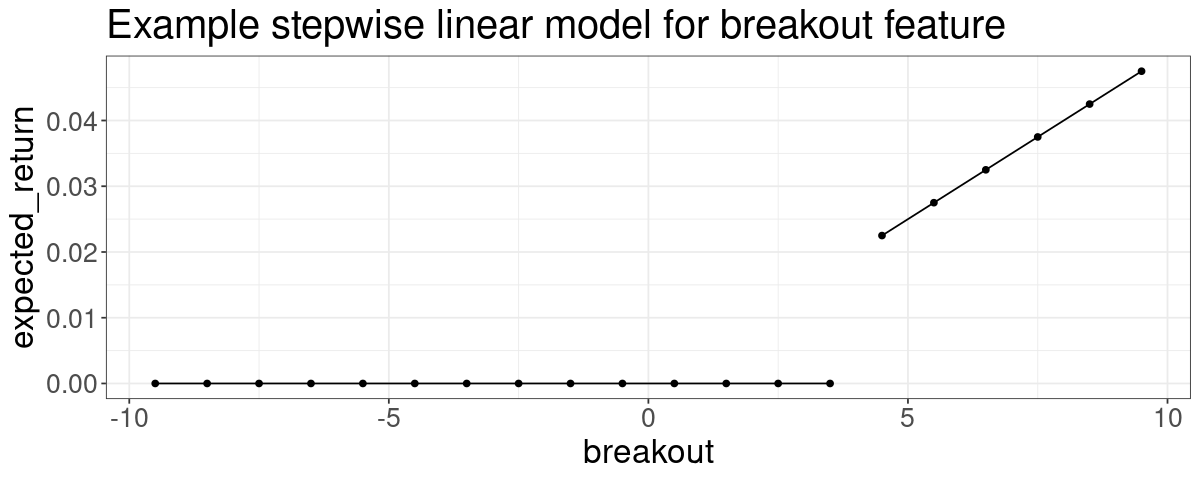

In [61]:
options(repr.plot.width = 10, repr.plot.height=4)
data.frame(breakout = seq(from = -9.5, to = 9.5, by = 1)) %>%
    mutate(expected_return = case_when(breakout <= 3.5 ~ 0, TRUE ~ breakout * 0.005)) %>%
    mutate(groups = case_when(breakout <= 3.5 ~ 0, TRUE ~ 1)) %>%
    ggplot(aes(x = breakout, y = expected_return, group = groups)) +
    geom_line() +
    geom_point() +
    labs(
        title = "Example stepwise linear model for breakout feature"
    )

It would also be quite acceptable to model this feature’s expected returns as zero from -9.5 through 3.5 and the mean of the expected returns to the remaining deciles above 3.5:

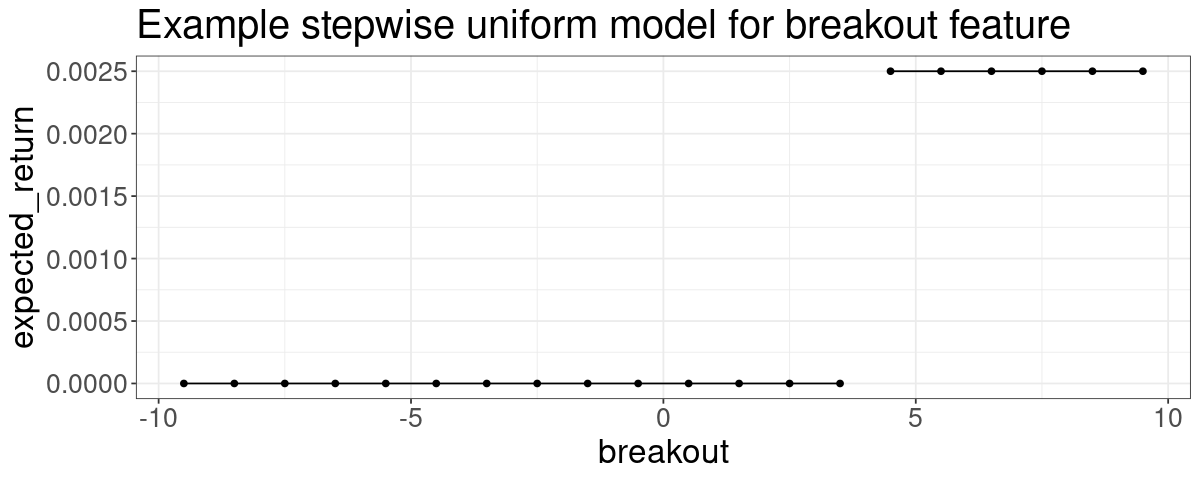

In [62]:
data.frame(breakout = seq(from = -9.5, to = 9.5, by = 1)) %>%
    mutate(expected_return = case_when(breakout <= 3.5 ~ 0, TRUE ~ 0.0025)) %>%
    mutate(groups = case_when(breakout <= 3.5 ~ 0, TRUE ~ 1)) %>%
    ggplot(aes(x = breakout, y = expected_return, group = groups)) +
    geom_line() +
    geom_point() +
    labs(
        title = "Example stepwise uniform model for breakout feature"
    )
# session  options
options(repr.plot.width = 14, repr.plot.height=7)

This has the advantage of simplicity, but I do think that it makes sense that this feature would behave linearly at the top end (that is, expected returns are higher the closer we are to the 20-day high).

## Delta Decile

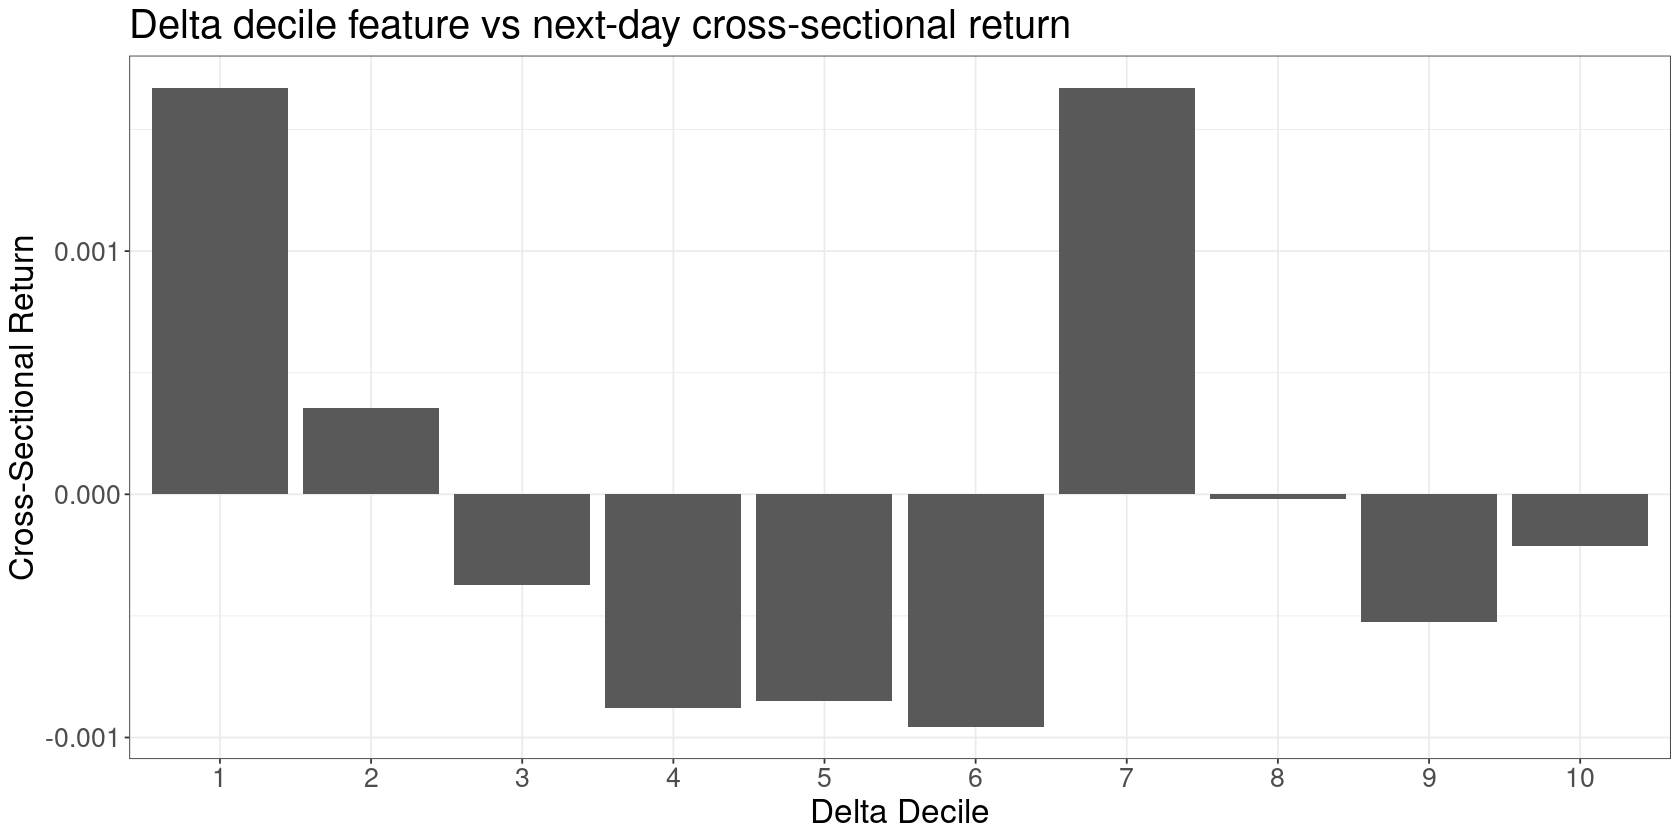

In [68]:
model_df %>%
  group_by(delta_decile) %>%
  summarise(mean_return = mean(demeaned_fwd_return)) %>%
  ggplot(aes(x = factor(delta_decile), y = mean_return)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Delta Decile",
    y = "Cross-Sectional Return",
    title = "Delta decile feature vs next-day cross-sectional return"
  )

Let’s see how this feature’s relationship with forward returns has changed over time. We’ll plot a factor plot for each year in our data set:

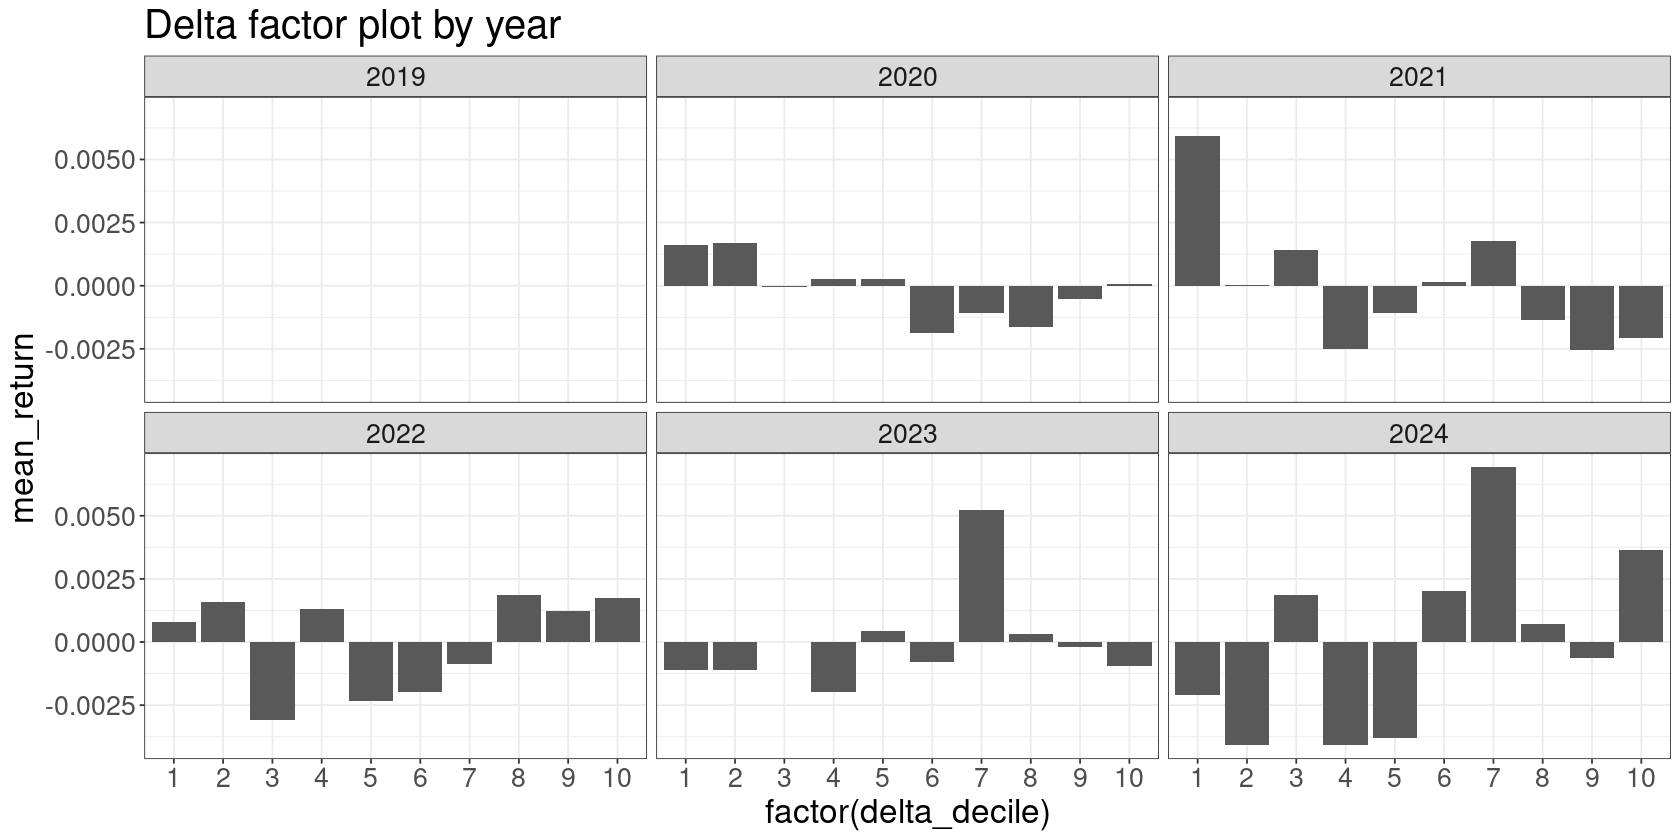

In [70]:
model_df %>%
  mutate(Year = year(date)) %>%
  group_by(delta_decile, Year) %>%
  summarise(mean_return = mean(demeaned_fwd_return, na.rm = TRUE), .groups = "drop") %>%
  ggplot(aes(x = factor(delta_decile), y = mean_return)) +
  geom_bar(stat = "identity") +
  facet_wrap(~Year) +
  labs(
    title = "Delta factor plot by year"
  )

## Models

Now that we have a reasonable specification for our models, let’s go ahead and build them.

This is slightly complicated by the fact that we should do this on a rolling basis, only including information that was available at the time.

This leads to rolling estimates for our model coefficients.

These rolling regressions were once a bit of a pain to set up, but the tidymodels ecosystem now makes this quite simple and intuitive and integrates with the rest of the tidyverse.

This modeling ecosystem is incredibly rich and provides a single interface to many model specifications. The caret package was an early attempt at this, but tidymodels takes it further with tight integration with the rest of the tidyverse and a consistent interface regardless of the model type.

An example of this richness is that we can estimate a standard linear model using ordinary least squares with lm. But we can also estimate one with robust standard errors (for example, accounting for autocorrelation and heteroscedasicity) by simply passing the vcov. argument, which will instead fit the model using the sandwich package – all without changing the model interface. Very cool. This won’t make much difference in this application, but I’ll include it in the example.

We’ll fit our model on 90-day windows of data, and refit every 10 days. 90 days doesn’t sound like a lot of data, but in general I find that fitting to the recent past tends to work better.


In [71]:
# use a 90-day window and refit every 10 days
is_days <- 90
step_size <- trading_universe_size*10

# rolling model for cross-sectional features
roll_xs_coeffs_df <- model_df %>%
  filter(date >= start_date) %>%
  regress(
    demeaned_fwd_return ~ carry_decile + momo_decile,
    m("lm", vcov. = "HAC"),
    .cv = "sliding_index",
    .cv_args = list(lookback = days(is_days), step = step_size, index = "date"),
    .force_cv = TRUE,
    .return_slices = TRUE
  )

# rolling model for time series features
breakout_cutoff <- 5.5  # below this level, we set our expected return to zero
roll_ts_coeffs_df <- model_df %>%
  filter(date >= start_date) %>%
  # setting regression weights to zero when breakout < breakout_cutoff will give these data points zero weight in estimating coefficients
  mutate(regression_weights = case_when(breakout < breakout_cutoff ~ 0, TRUE ~ 1)) %>%
  regress(
    total_fwd_return_simple ~ breakout,
    m("lm", vcov. = "HAC"),
    .weights = "regression_weights",
    .cv = "sliding_index",
    .cv_args = list(lookback = days(is_days), step = step_size, index = "date"),
    .force_cv = TRUE,
    .return_slices = TRUE
  )

In [ ]:
roll_xs_coeffs_df %>% head
roll_ts_coeffs_df %>% select(-settings) %>% head

In [ ]:
install.packages("lmtest")
install.packages("sandwich")

In [80]:
library(lmtest)
library(sandwich)

In [81]:
# for this to work, need to install.packages("sandwich", "lmtest")
xs_coefs <- roll_xs_coeffs_df %>%
  coef()

xs_coefs_df <- xs_coefs %>%
  ungroup() %>%
  select(term, estimate, slice_id) %>%
  pivot_wider(id_cols = slice_id, names_from = term, values_from = estimate) %>%
  mutate(slice_id = as_date(slice_id)) %>%
  # need to lag slice id to make it oos
  # slice_id_oos is the date we start using the parameters
  mutate(slice_id_oos = lead(slice_id)) %>%
  rename("xs_intercept" = `(Intercept)`)

ts_coefs <- roll_ts_coeffs_df %>%
  coef()

ts_coefs_df <- ts_coefs %>%
  ungroup() %>%
  select(term, estimate, slice_id) %>%
  pivot_wider(id_cols = slice_id, names_from = term, values_from = estimate) %>%
  mutate(slice_id = as_date(slice_id)) %>%
  # need to lag slice id to make it oos
  # slice_id_oos is the date we start using the parameters
  mutate(slice_id_oos = lead(slice_id)) %>%
  rename("ts_intercept" = `(Intercept)`)

xs_coefs_df %>% head
# ts_coefs_df %>% head

slice_id,xs_intercept,carry_decile,momo_decile,slice_id_oos
<date>,<dbl>,<dbl>,<dbl>,<date>
2021-02-11,-0.004872208,0.001732322,-0.0008239738,2021-02-21
2021-02-21,-0.006129608,0.001902553,-0.0007640190,2021-03-03
2021-03-03,-0.009538180,0.002148154,-0.0003897220,2021-03-13
2021-03-13,-0.008374302,0.001953655,-0.0004141515,2021-03-23
2021-03-23,-0.008275046,0.002211137,-0.0006898811,2021-04-02
2021-04-02,-0.008613423,0.002413307,-0.0008298451,2021-04-12


In [83]:
Here’s a plot of our cross-sectional features’ regression coefficients through time:


ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected input
1: Here’
        ^


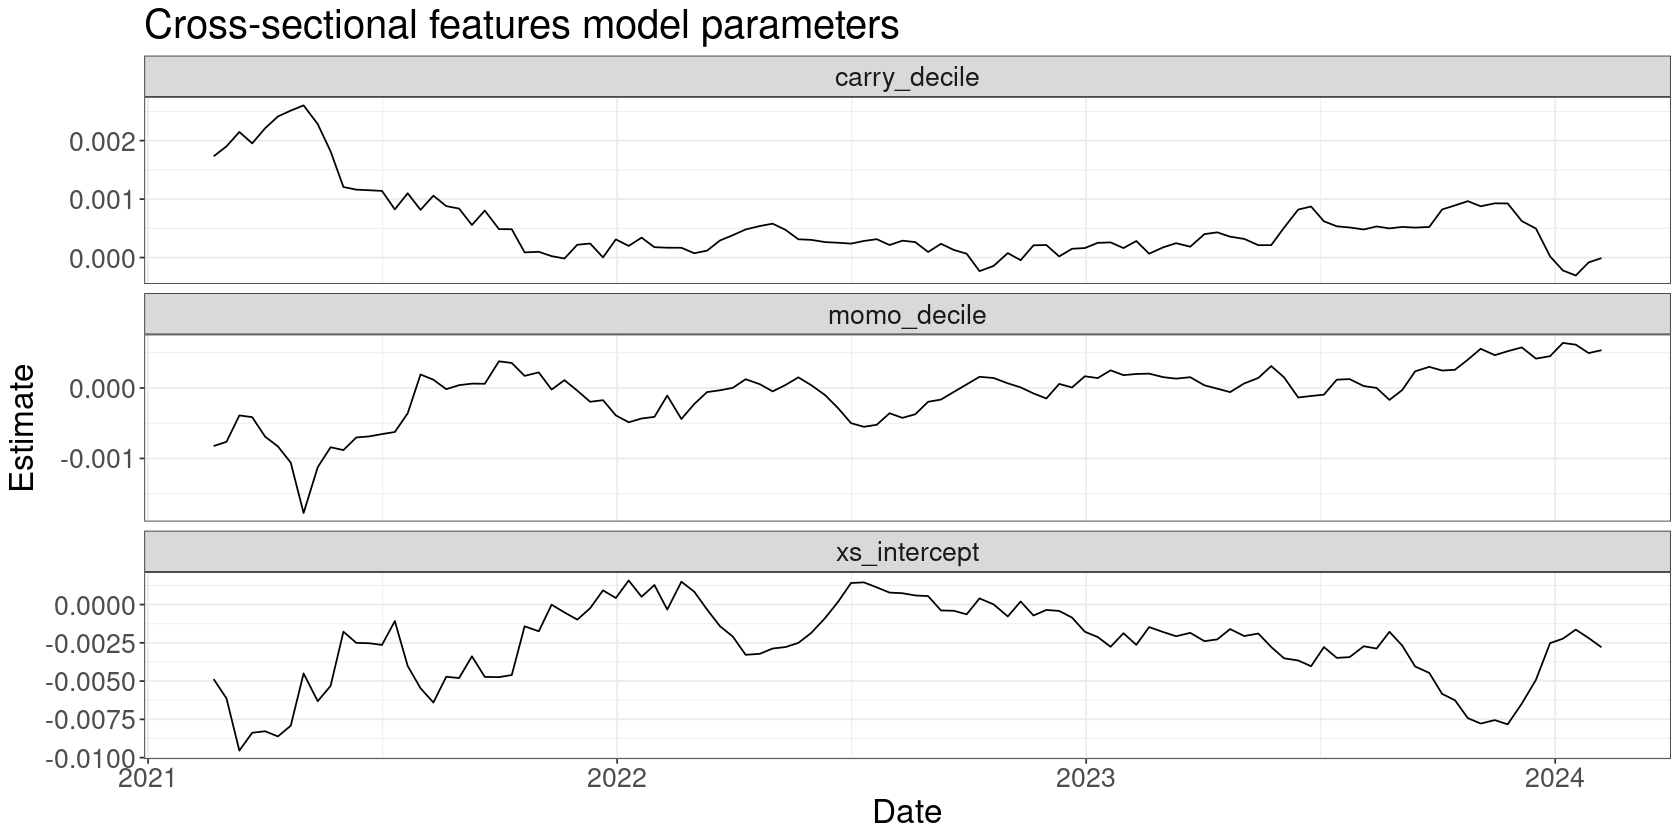

In [84]:
# plot cross-sectional estimates
xs_coefs_df %>%
  select(-slice_id) %>%
  pivot_longer(cols = -slice_id_oos, names_to = "coefficient", values_to = "estimate") %>%
  ggplot(aes(x = slice_id_oos, y = estimate)) +
  geom_line() +
  facet_wrap(~coefficient, ncol = 1, scales = "free_y") +
  labs(
    title = "Cross-sectional features model parameters",
    x = "Date",
    y = "Estimate"
  )

# plot time-series estimates
# ts_coefs_df %>%
#   select(-slice_id) %>%
#   pivot_longer(cols = -slice_id_oos, names_to = "coefficient", values_to = "estimate") %>%
#   ggplot(aes(x = slice_id_oos, y = estimate)) +
#   geom_line() +
#   facet_wrap(~coefficient, ncol = 1, scales = "free_y") +
#   labs(
#     title = "Time-series features model parameters",
#     x = "Date",
#     y = "Estimate"
#   )

The estimates for the model coefficients for our carry and momentum features change over time to reflect the changing relationship with forward returns.

In particular, notice how the momentum coefficient flipped sign a few times, but especially from mid-2022, which is in line with our understanding of how the feature evolved.

Now we can plot a time series of returns to a frictionless trading strategy based on these expected return estimates. This isn’t a backtest – it makes no attempt to address real-world issues such as costs and turnover. It simply plots the returns to our predictions of expected returns over time.

I won’t actually use the linear model of the breakout feature – instead I’ll just set its expected return to 0.002 when it’s greater than 5 and 0 otherwise. I don’t like that the breakout coefficients go negative from time to time.

I’ll calculate target positions proportional to their cross-sectional return estimates. I’ll then let the breakout feature tilt the portfolio net long, but I’ll constrain the maximum delta that this feature can add to a position.


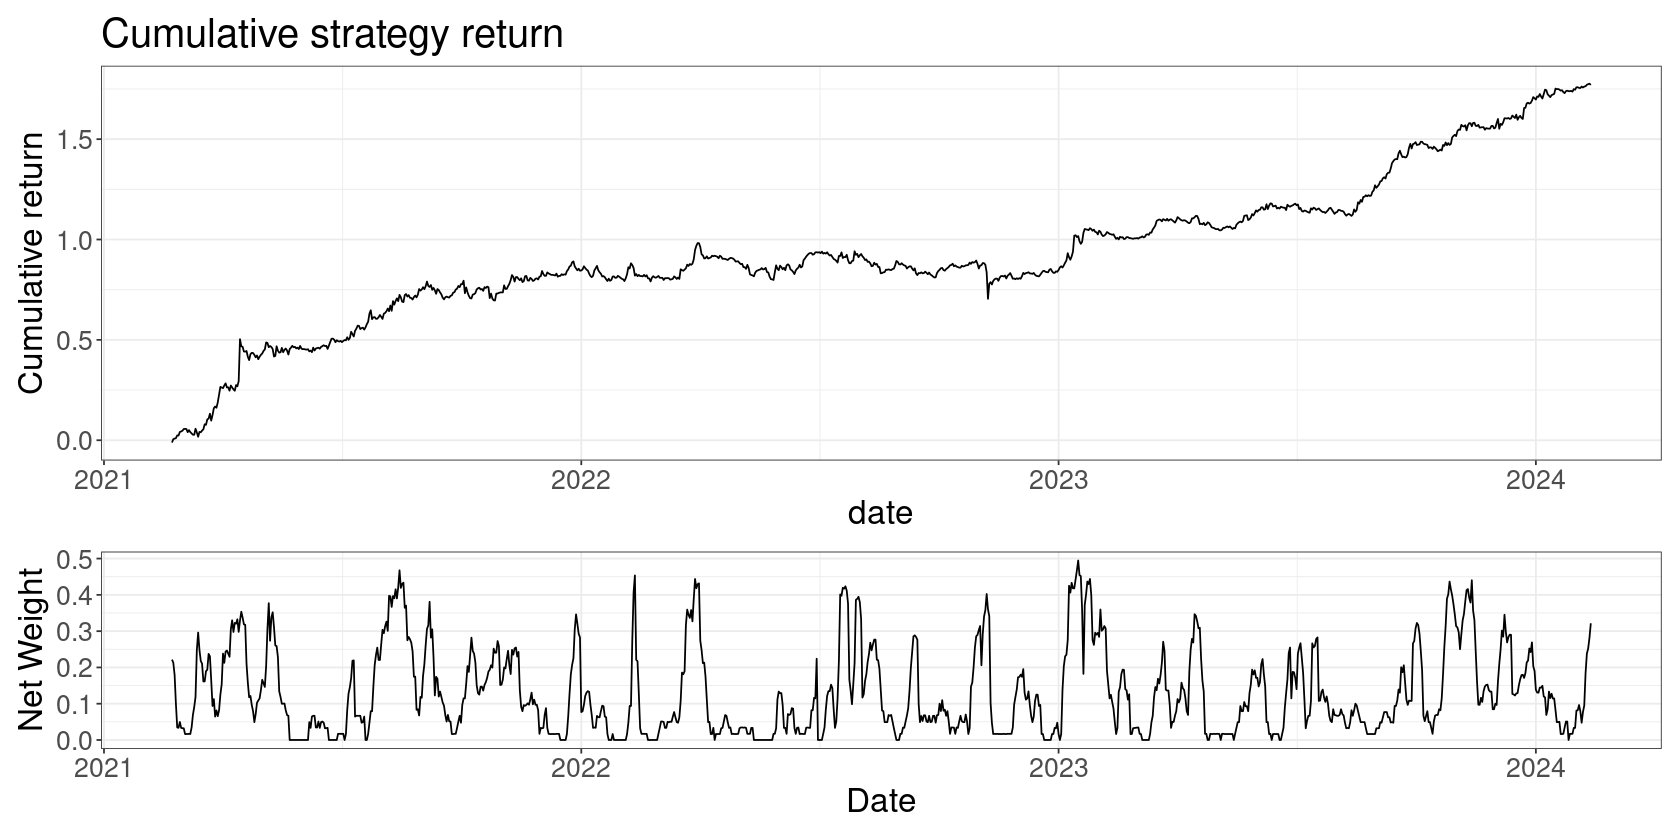

In [86]:
# join and fill using slice_id to designate when the model goes oos
exp_return_df <- model_df %>%
  left_join(
    xs_coefs_df %>% left_join(ts_coefs_df, by = c("slice_id", "slice_id_oos")),
    by = join_by(closest(date > slice_id_oos)), suffix = c("_factor", "_coef")
  ) %>%
  na.omit() %>%
  # forecast cross-sectional expected return as
  mutate(expected_xs_return = carry_decile_factor*carry_decile_coef + momo_decile_factor*momo_decile_coef + xs_intercept ) %>%
  # mean expected xs return each day is zero
  # let total expected return be xs return + ts return - allows time series expected return to tilt weights
  mutate(expected_ts_return = case_when(breakout_factor >= 5.5 ~ 0.002, TRUE ~ 0)) %>%
  ungroup()

# long-short the xs expected return
# layer ts expected return on top
# position by expected return

# 1 in the numerator lets it get max 100% long due to breakout
max_ts_pos <- 0.5/trading_universe_size

strategy_df <- exp_return_df %>%
  filter(date >= start_date) %>%
  group_by(date) %>%
  mutate(xs_position = expected_xs_return - mean(expected_xs_return, na.rm = TRUE)) %>%
  # scale positions so that leverage is 1
  group_by(date) %>%
  mutate(xs_position = if_else(xs_position == 0, 0, xs_position/sum(abs(xs_position)))) %>%
  # layer ts expected return prediction
  ungroup() %>%
  mutate(ts_position = sign(expected_ts_return)) %>%
  # constrain maximum delta added by time series prediction
  mutate(ts_position = if_else(ts_position >= 0, pmin(ts_position, max_ts_pos), pmax(ts_position, -max_ts_pos))) %>%
  mutate(position = xs_position + ts_position) %>%
  # strategy return
  mutate(strat_return = position*total_fwd_return_simple) %>%
  # scale back to leverage 1
  group_by(date) %>%
  mutate(position = if_else(position == 0, 0, position/sum(abs(position))))

returns_plot <- strategy_df %>%
  group_by(date) %>%
  summarise(total_ret = sum(strat_return)) %>%
  ggplot(aes(x = date, y = cumsum(log(1+total_ret)))) +
  geom_line() +
  labs(
    title = "Cumulative strategy return",
    y = "Cumulative return"
  )

weights_plot <- strategy_df %>%
  summarise(net_pos = sum(position)) %>%
  ggplot(aes(x = date, y = net_pos)) +
  geom_line() +
  labs(
    x = "Date",
    y = "Net Weight"
  )

returns_plot / weights_plot + plot_layout(heights = c(2,1))

Notice that I still had to make some manual adjustments to the positions resulting from the time-series predictions which were quite imprecise (for instance, using the sign of the prediction as the position then scaling it back using a maximum delta constraint).

This is OK, but I’d rather use my predictions a little more directly. I want to model my features as best I can, and then at each decision point, I want to answer the question “Given these expected returns, what’s the best portfolio given my constraints?” That’s an optimisation problem, and one that we can actually solve without resorting to manual adjustments and heuristics. I’ll show you how to do that in the next article.

But first, let’s do a more accurate simulation given our target weights and trading costs. We’ll use rsims, like in the previous example.

First, wrangle our data into matrixes of target positions, prices, and funding rates:


In [87]:
# get weights as a wide matrix
# note that date column will get converted to unix timestamp
backtest_weights <- strategy_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, position)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("position_")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- strategy_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, position)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

# get funding as a wide matrix
# note that date column will get converted to unix timestamp
backtest_funding <- strategy_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(date, starts_with("funding_rate_")) %>%
  data.matrix()

head(backtest_funding, c(5, 5))

date,position_1INCHUSDT,position_AAVEUSDT,position_ADAUSDT,position_ALPHAUSDT
18680,0.002694931,0.01054433,0.0762376871,0.014704422
18681,0.027559434,-0.07675613,0.0125204272,-0.010399337
18682,0.040915764,-0.05302819,0.0012411217,0.002097874
18683,0.014953494,-0.02667621,0.0062533668,-0.010292540
18684,-0.023077149,0.01078900,0.0002980306,-0.023706301


date,close_1INCHUSDT,close_AAVEUSDT,close_ADAUSDT,close_ALPHAUSDT
18680,4.3783,399.582,0.98801,1.44859
18681,3.6600,347.445,0.97291,1.24510
18682,3.7108,384.990,1.02610,1.28602
18683,4.1634,379.815,1.12148,1.69307
18684,4.7594,340.026,1.16322,1.34361


date,funding_rate_1INCHUSDT,funding_rate_AAVEUSDT,funding_rate_ADAUSDT,funding_rate_ALPHAUSDT
18680,-0.00136194,-0.00031975,-0.00000653,-0.00142453
18681,-0.00025597,-0.00077154,-0.00030000,-0.00045960
18682,-0.00021475,-0.00030000,-0.00030000,-0.00030000
18683,-0.00040013,-0.00045891,-0.00060473,-0.00055099
18684,-0.00030000,-0.00010783,-0.00030000,-0.00048984


We’ll start with a cost-free simulation that trades frictionlessly into our target positions. The result should look a lot like the returns plot above:

In [88]:
# cost-free, no trade buffer
# simulation parameters
initial_cash <- 10000
fee_tier <- 0
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- 0.
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

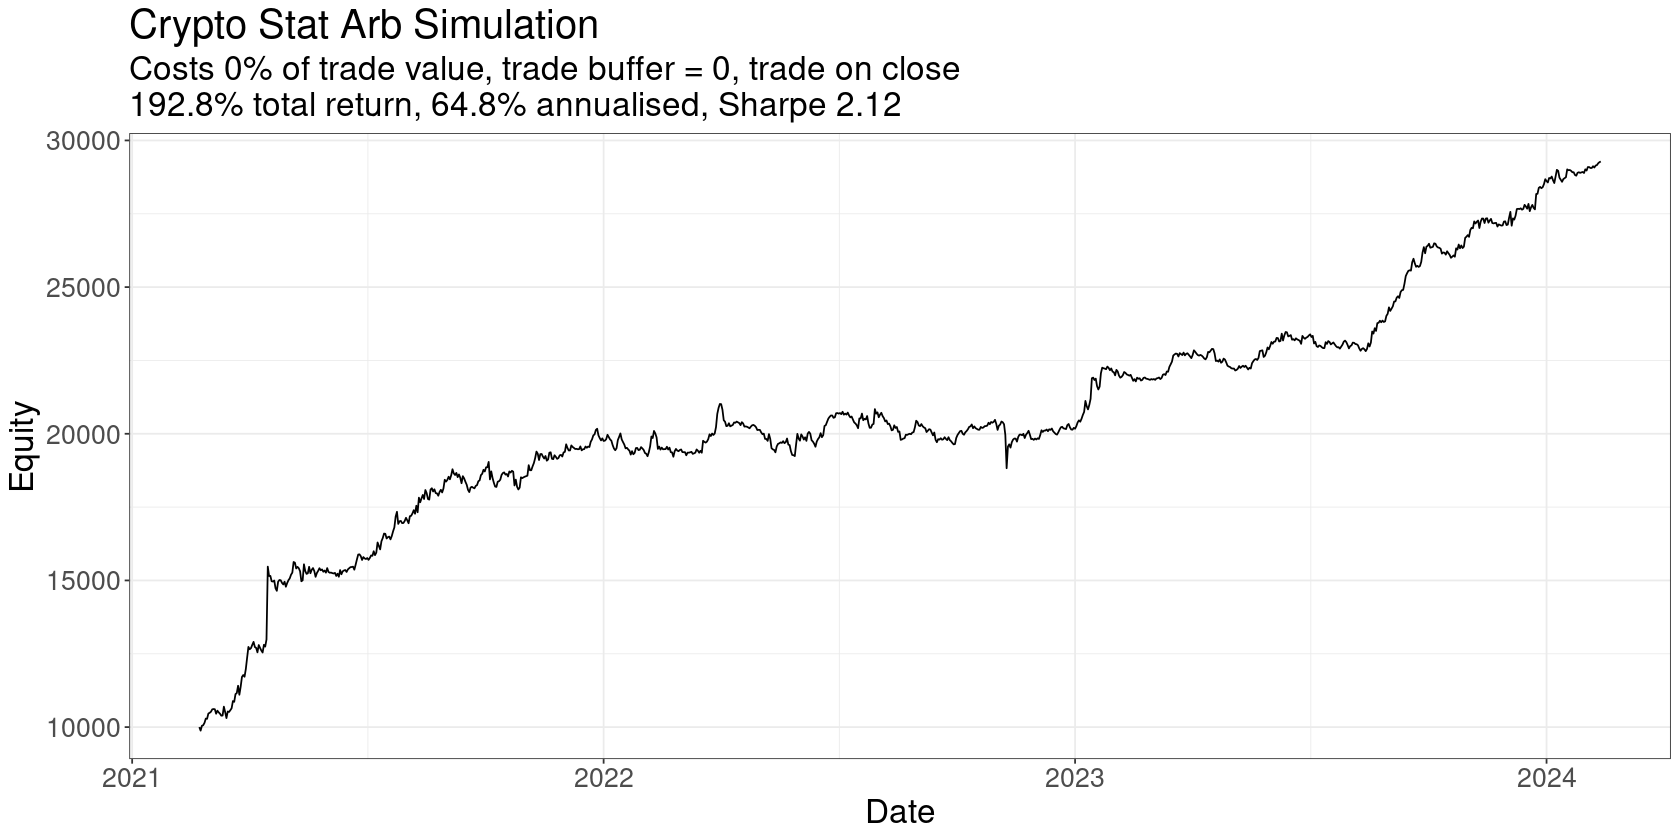

In [89]:
# make a nice plot with some summary statistics
# plot equity curve from output of simulation
plot_results <- function(backtest_results, trade_on = "close") {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

  fin_eq <- equity %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity)
  ann_return <- total_return * 365/days
  sharpe <- equity %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(365)*mean(returns)/sd(returns)) %>%
    pull()

  equity %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Crypto Stat Arb Simulation",
        subtitle = glue::glue(
          "Costs {commission_pct*100}% of trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

    equity %>%
        mutate(returns = Equity/lag(Equity)- 1) %>%
        na.omit() %>%
        summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
        pull()
}

plot_results(results_df)

Now we’ll add costs:

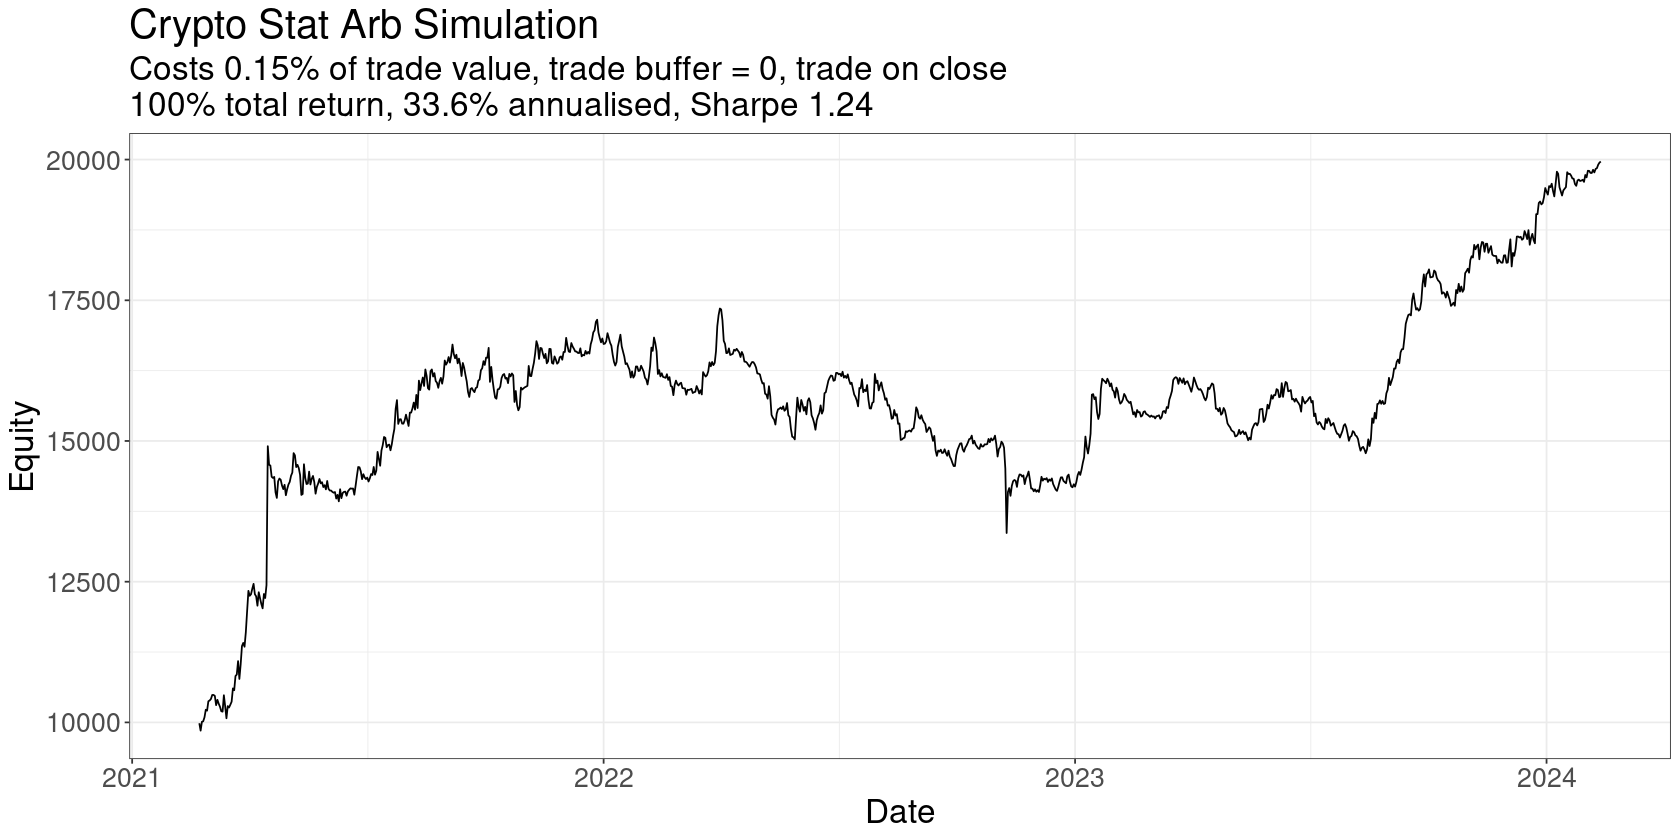

In [90]:
# explore costs-turnover tradeoffs
# with costs, no trade buffer
commission_pct <- 0.0015

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

results_df %>%
  plot_results()

Costs are quite a drag on performance. Let’s use the no-trade buffer heuristic from the last article to do the minimum amount of trading to harness the edge:

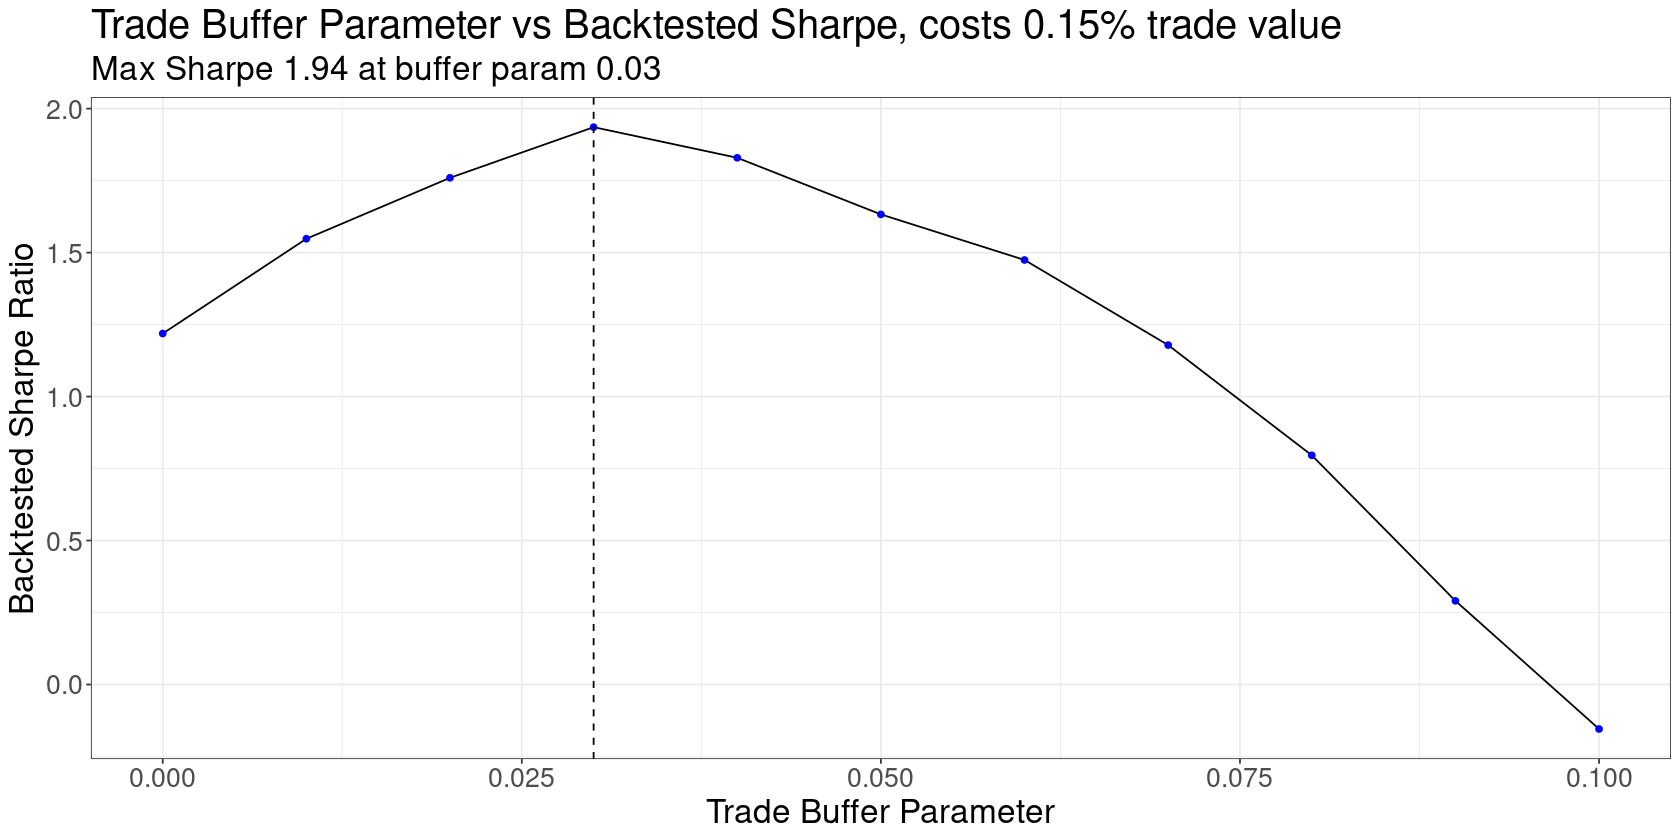

In [91]:
# find appropriate trade buffer by optimising historical sharpe
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    fixed_commission_backtest_with_funding(
      prices = backtest_prices,
      target_weights = backtest_weights,
      funding_rates = backtest_funding,
      trade_buffer = trade_buffer,
      initial_cash = initial_cash,
      margin = margin,
      commission_pct = commission_pct,
      capitalise_profits = capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue::glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue::glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

A value of 0.03 maximised our historical after-cost Sharpe. You might pick a value a little higher than 0.03 to mitigate the risk that your out-of-sample performance will be worse than your in-sample (almost always a good assumption). But for now, let’s just simulate 0.03:

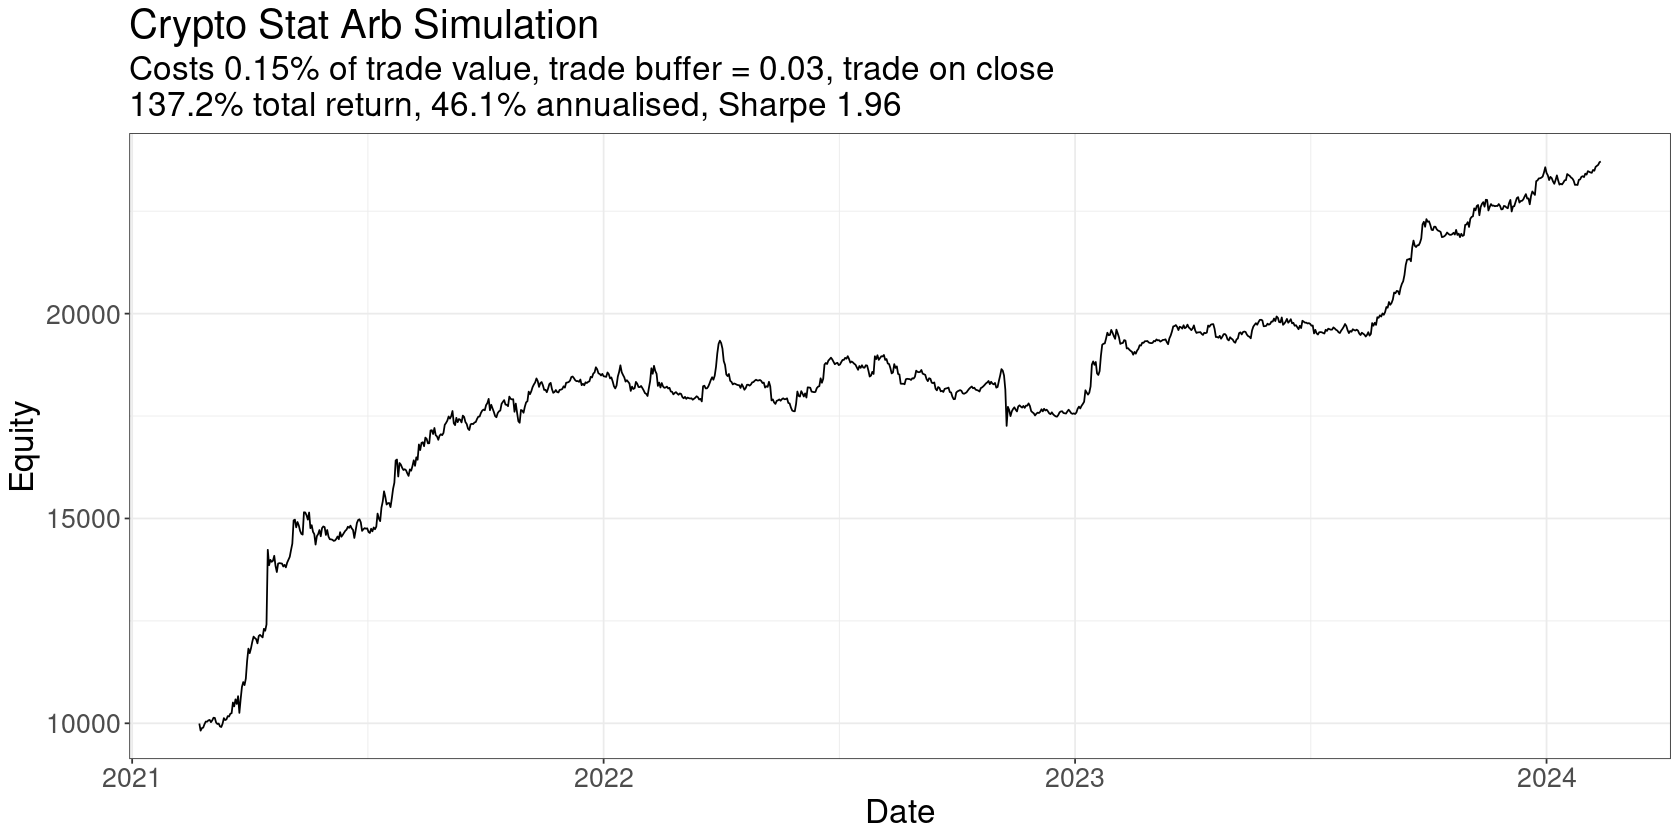

In [92]:
# get back original with costs simulation results
trade_buffer <- 0.03

# simulation
results_df <- fixed_commission_backtest_with_funding(
    prices = backtest_prices,
    target_weights = backtest_weights,
    funding_rates = backtest_funding,
    trade_buffer = trade_buffer,
    initial_cash = initial_cash,
    margin = margin,
    commission_pct = commission_pct,
    capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

# simulation results
results_df %>%
  plot_results()

Performance is a little higher with this approach (note that this simulation starts later than the previous one because we have to exclude the first in-sample model estimation period – over the same period, this one does better, especially recently).

Turnover is a bit higher, but that’s more to do with the lower trade buffer parameter selected:


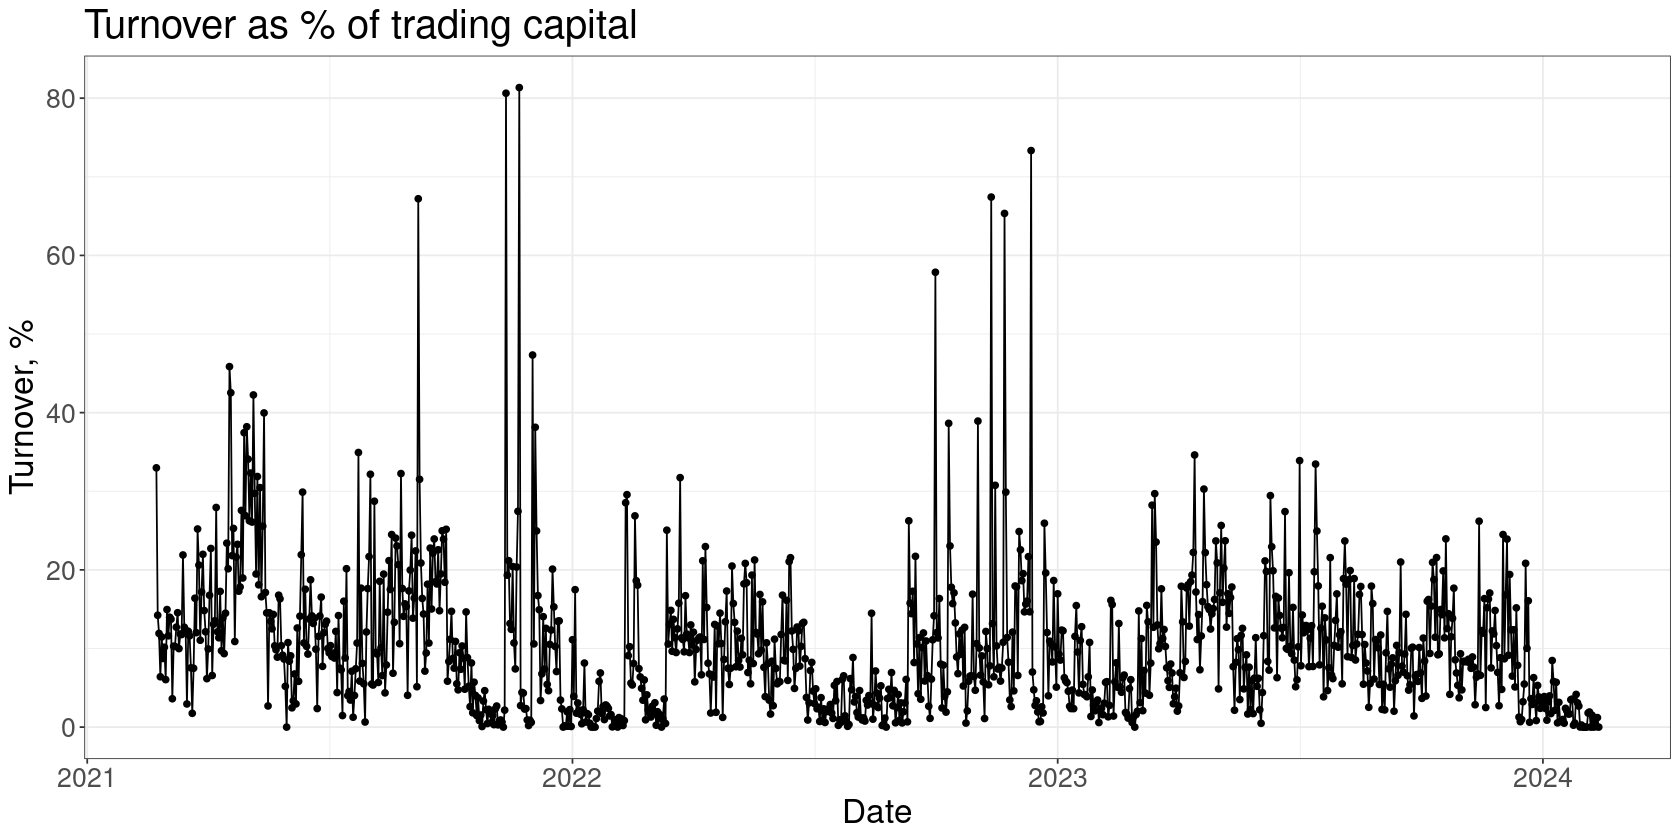

In [94]:
results_df %>%
  filter(ticker != "Cash") %>%
  group_by(Date) %>%
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>%
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

While this is a good result for such a simple modeling approach, the main benefit of this approach is that your features are all modelled on the same scale, making them directly comparable. It also means that incorporating new signals into your system is straightforward and follows the same modeling process. We also saw that we can potentially capture changing feature dynamics directly in the modeling process. 